In [52]:
# Imports
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import notebook
import seaborn as sns

import importlib
import msciLib
importlib.reload(msciLib)
import pickle

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor

In [18]:
# Flags 
graph = False

# Seeds
import random
random.seed(42)
from numpy.random import seed
seed(42)
import tensorflow
tensorflow.random.set_seed(3)

# Make Training and Test Indicies

Matrix has data from 1827 tickers and each ticker has 5 of its features included, excluding the 6th OpenInt.  

In [19]:
# Load clean matrix and tickers
matrix_3201 = np.load("formatted_data/matrix_3201.npy")
tickers_3201 = np.load("formatted_data/tickers_3201.npy")
number_of_examples = matrix_3201.shape[0]

In [20]:
# Train and test indicies
train_indicies, test_indicies = msciLib.construct_train_test_indicies(number_of_examples)

In [21]:
# Size and shape of Datasets
print("Number of examples in dataset (dates): {}".format(number_of_examples))
print("Number of examples in training set:    {}".format(len(train_indicies)))
print("Number of examples in test set:        {}".format(len(test_indicies)))

Number of examples in dataset (dates): 3201
Number of examples in training set:    1600
Number of examples in test set:        1601


# Plot 'close' for 3 Random Tickers

In [22]:
# Grab three random tickers
random.seed(42)
ticker_index1, ticker_index2, ticker_index3 = random.sample(range(0, len(tickers_3201)), 3)
print("The three tickers chosen: {}, {}, {}".format(
    tickers_3201[ticker_index1], tickers_3201[ticker_index2], tickers_3201[ticker_index3]))

The three tickers chosen: plab, bwa, ajrd


In [23]:
sns.set_style("darkgrid")

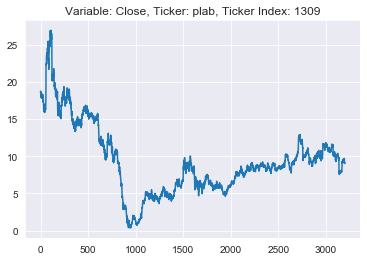

In [24]:
msciLib.plot_ticker(matrix_3201, tickers_3201, ticker_index1, "Close")

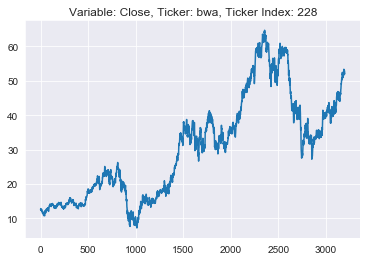

In [25]:
msciLib.plot_ticker(matrix_3201, tickers_3201, ticker_index2, "Close")

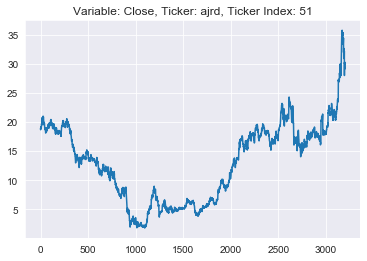

In [26]:
msciLib.plot_ticker(matrix_3201, tickers_3201, ticker_index3, "Close")

# Training

## Training for thrid random ticker 'ajrd'

In [27]:
# Make training and testing sets.
train_set, train_target, test_set, test_target = msciLib.construct_train_test_sets(matrix_3201, ticker_index3, "close")

In [28]:
# Shape of the sets
print(train_set.shape)
print(train_target.shape)
print(test_set.shape)
print(test_target.shape)

(1600, 9134)
(1600,)
(1601, 9134)
(1601,)


In [29]:
# def create_model():
#     # create model
#     model = Sequential()
#     model.add(Dense(10, input_dim=train_set.shape[1], activation='relu'))
#     model.add(Dense(50, activation='sigmoid'))
#     model.add(Dense(40, activation='relu'))
#     # model.add(Dense(25, activation='relu'))
#     model.add(Dense(1))
#     # Compile model
#     model.compile(optimizer ='adam', loss = 'mean_absolute_percentage_error', 
#               metrics =[metrics.mape])
#     return model

In [30]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(100, input_dim=train_set.shape[1], activation='relu'))
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer ='adam', loss = 'mean_absolute_percentage_error', 
              metrics =[metrics.mape])
    return model

In [31]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               913500    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 41        
Total params: 937,781
Trainable params: 937,781
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(train_set, train_target, validation_data=(test_set, test_target), epochs=500, batch_size=32, 
                    verbose = False)

In [51]:
model.save("models/demoModel.h5")

In [54]:
with open('models/demoModel_trainHistory', 'wb') as pickle_file:
        pickle.dump(history.history, pickle_file)

# Analysis

## Loss Plot

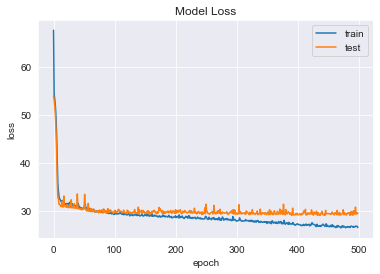

In [33]:
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
#plt.ylim(20, 2000)
#plt.xlim(10,)
plt.show()

## Predict on Test Set and Plot

In [34]:
# Get predictions
prediction = model.predict(test_set)

In [35]:
# Order the shuffled test_target and prediction in chronological order. 
ordered_target = np.full(number_of_examples, -1)
ordered_pred = np.full(number_of_examples, -1)

for i in np.arange(len(test_indicies)):
    ordered_target[test_indicies[i]] = test_target[i]
    ordered_pred[test_indicies[i]] = prediction[i]

(-1, 3365.782562147697)

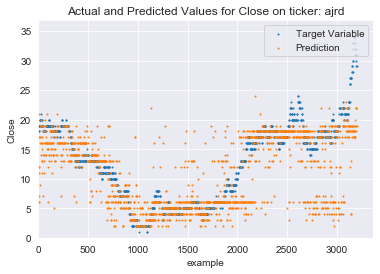

In [57]:
# Plot the target and prediction values
plt.scatter(np.arange(number_of_examples), ordered_target, s = 1)
plt.scatter(np.arange(number_of_examples), ordered_pred, s = 1)

# plt.plot(ordered_target, linewidth = 1)
# plt.plot(ordered_pred, linewidth = 1)

plt.title("Actual and Predicted Values for Close on ticker: {}".format(tickers_3201[ticker_index3]))
plt.ylabel('Close')
plt.xlabel('example')
plt.legend(['Target Variable', 'Prediction'], loc='upper right')
plt.ylim(0, )
plt.xlim(-1, )

### Compare prediction MAPE vs. base case MAPE

In [44]:
msciLib.calculate_mape(test_target, prediction)

129318.13297857321

In [47]:
msciLib.calculate_basecase_mape(matrix_3201, ticker_index3, "close")

1.872097557242246

In [49]:
test_target - prediction

array([[  6.89432915,  -2.66567085,  11.64432915, ..., -14.16567085,
        -11.92567085,  14.90432915],
       [  9.02591522,  -0.53408478,  13.77591522, ..., -12.03408478,
         -9.79408478,  17.03591522],
       [  4.72921761,  -4.83078239,   9.47921761, ..., -16.33078239,
        -14.09078239,  12.73921761],
       ...,
       [ 21.38092001,  11.82092001,  26.13092001, ...,   0.32092001,
          2.56092001,  29.39092001],
       [ 21.38092001,  11.82092001,  26.13092001, ...,   0.32092001,
          2.56092001,  29.39092001],
       [  7.09155281,  -2.46844719,  11.84155281, ..., -13.96844719,
        -11.72844719,  15.10155281]])